In [1]:
import fitsio
import numpy as np
f = fitsio.read('focusdata.fits')

In [2]:
from matplotlib import pyplot as plt
from table import LUT_table #this is what does LUT interpolation, AJR made fixes to nearest neighbor finding
mt = (f['TTRUTSBT']+f['TTRUTSMT']+f['TTRUTSTT'])/3. #the temperatures used for autofocus
af = -8400+(7.-mt)*110 #the autofocus equation
lut = LUT_table('20190415frommartinilut_v2.txt') #Look up table
'''
make array with focus values from LUT
'''
zlut = np.zeros(len(af))
for i in range(0,len(f)):
    zlut[i] = lut.interpolate_delaunay(f[i]['MOUNTAZ'],f[i]['MOUNTEL'])[2] #get values, code reports when uses nearest neighbor

aflut = af -(zlut+8400) #auto focus + look up table, with signs reversed based on analysis below

Loaded 20190415frommartinilut_v2.txt
Replace nan with nearest -2000.0 for element 0
Replace nan with nearest -4000.0 for element 1
Replace nan with nearest -8400.0 for element 2
Replace nan with nearest -100.0 for element 3
Replace nan with nearest 25.0 for element 4
Replace nan with nearest 0.0 for element 5
Replace nan with nearest -1888.45 for element 0
Replace nan with nearest -4088.52 for element 1
Replace nan with nearest -8433.69 for element 2
Replace nan with nearest -107.38 for element 3
Replace nan with nearest 34.31 for element 4
Replace nan with nearest 0.0 for element 5
Replace nan with nearest -1994.26 for element 0
Replace nan with nearest -4142.64 for element 1
Replace nan with nearest -8437.0 for element 2
Replace nan with nearest -111.9 for element 3
Replace nan with nearest 25.48 for element 4
Replace nan with nearest 0.0 for element 5
Replace nan with nearest -2000.0 for element 0
Replace nan with nearest -4000.0 for element 1
Replace nan with nearest -8400.0 for el

/global/u2/a/ajross/table.py:277: UserWarning: Warning: converting a masked element to nan.
  if repr(val)=='nan' or math.isnan(val):


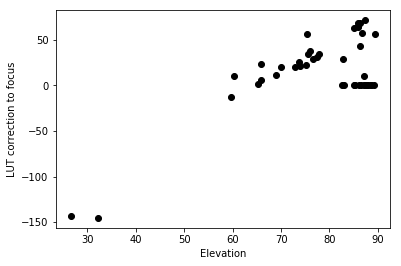

In [3]:
'''
plot elevation vs LUT difference to see that results make sense
points near 90,0 were nearest neighbors to az,el 0,90 and get the fiducial value
'''
plt.plot(f['MOUNTEL'],aflut-af,'ko')
plt.xlabel('Elevation')
plt.ylabel('LUT correction to focus')
plt.show()

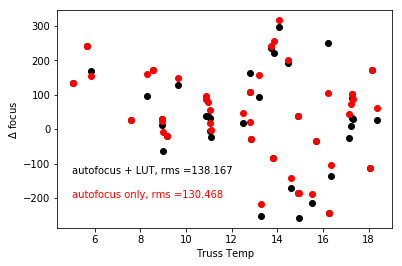

In [4]:
plt.plot(mt,f['focus_C']-aflut,'ko')
rmsl = np.std(f['focus_C']-aflut-np.mean(f['focus_C']-aflut))
plt.text(5,-130,'autofocus + LUT, rms ='+str(np.round(rmsl,3)),color='k')
plt.plot(mt,f['focus_C']-af,'ro')
rmsn = np.std(f['focus_C']-af-np.mean(f['focus_C']-af))
plt.text(5,-200,'autofocus only, rms ='+str(np.round(rmsn,3)),color='r')
plt.xlabel('Truss Temp')
plt.ylabel(r'$\Delta$ focus')
plt.show()

In [5]:
'''
So, the autofocus actually makes things slightly worse compared to just autofocus
Below, look just at temperature focus relationships and then revisit LUT
'''

'\nSo, the autofocus actually makes things slightly worse compared to just autofocus\nBelow, look just at temperature focus relationships and then revisit LUT\n'

coefficients are
-119.951547577 -7457.40231156


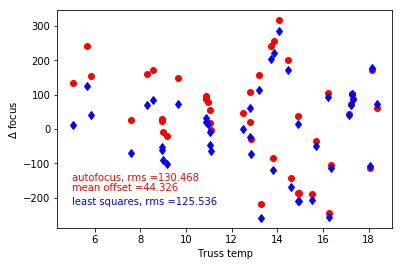

'\nleast-squares not that much better than autofocus\n'

In [6]:
'''
least squares between truss temp and CIC focus
'''
A = np.vstack([mt, np.ones(len(mt))]).T
m, c = np.linalg.lstsq(A, f['focus_C'])[0]
afme = m*mt+c
print('coefficients are')
print(m,c)
'''
compare fit and autofocus residual
'''
plt.plot(mt,f['focus_C']-af,'ro')
rmsa = np.std(f['focus_C']-af)
am = np.mean(f['focus_C']-af)
plt.text(5,-150,'autofocus, rms ='+str(np.round(rmsa,3)),color='r')
plt.text(5,-180,'mean offset ='+str(np.round(am,3)),color='r')
plt.plot(mt,f['focus_C']-afme,'bd')
rmsm = np.std(f['focus_C']-afme)
plt.text(5,-220,'least squares, rms ='+str(np.round(rmsm,3)),color='b')
plt.xlabel('Truss temp')
plt.ylabel(r'$\Delta$ focus')
plt.show()
'''
least-squares not that much better than autofocus
'''

In [7]:
'''
Now see what correlates with focus least-square residuals
look at available temperatures and temperature differences
some quantities are basically null tests and give an idea of the random noise
'''
df = f['focus_C']-afme
vl = []
ql = []
hquant = ['TARGTRA','TARGTDEC','MOUNTHA','MOUNTAZ','MOUNTEL','AIRMASS','CI-T1','CI-T2','CI-T3','CI-T4','CI-T5','TDEWPNT','TAIRFLOW','TAIRITMP','TAIROTMP','TAIRTEMP','TCASITMP','TCASOTMP','TCSITEMP','TCSOTEMP','TDBTEMP','TPMNIBT','TPMEOBT','TTRSTEMP','TTRWTEMP','TTRUETBT','TTRUETTT','TTRUNTBT','TTRUNTTT','TTRUSTBT','TTRUSTST','TTRUSTTT','TTRUTSBT','TTRUTSMT','TTRUTSTT','TTRUWTBT','TTRUWTTT','AMNIENTN','AMBIENTS','OUTTEMP','TELBASE']
for q in hquant:
    w = (f[q] != 0) #some quantities are 0 when there was no data
    w &= (f[q]*0 == 0)#some quantities are NaN
    print(q,np.corrcoef(f[w][q],df[w])[0][1],len(f[w]))
    vl.append(np.corrcoef(f[w][q],df[w])[0][1])
    ql.append(q)
    dq = f[q][w]-mt[w]
    print(np.corrcoef(dq,df[w])[0][1],len(f[w]))
    vl.append(np.corrcoef(dq,df[w])[0][1])
    ql.append('d'+q)

TARGTRA 0.314255768638 45
0.308970748239 45
TARGTDEC 0.109781143677 45
0.108135911342 45
MOUNTHA 0.0935679304818 45
0.0922484640167 45
MOUNTAZ -0.069135771906 45
-0.0688639790416 45
MOUNTEL -0.156166479698 45
-0.152995105294 45
AIRMASS 0.0798433433767 45
0.0048713591967 45
CI-T1 -0.2574497245 45
-0.714440321764 45
CI-T2 -0.276967894429 45
-0.739258146182 45
CI-T3 -0.290297507527 45
-0.734493046131 45
CI-T4 -0.288406759467 45
-0.744255301052 45
CI-T5 -0.19228159772 45
-0.599099993119 45
TDEWPNT 0.147564867405 45
0.0831540630415 45
TAIRFLOW nan 1
nan 1
TAIRITMP -0.324773655764 45
-0.297215003439 45
TAIROTMP -0.303706022934 45
-0.250833320196 45
TAIRTEMP -0.000484627822892 45
-0.015941469035 45
TCASITMP nan 45
-5.02990949734e-15 45
TCASOTMP -0.132973201544 45
-0.544334562708 45
TCSITEMP -0.158828253488 45
-0.44157945494 45
TCSOTEMP -0.0839248553804 45
-0.617850702299 45
TDBTEMP -0.130591874757 45
-0.199387907703 45
TPMNIBT -0.449498061915 45
-0.495735249614 45
TPMEOBT -0.375870592522 45
-

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:3159: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:3093: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:3093: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:3168: RuntimeWarning: in

In [8]:
'''
print out most significant correlations
'''
vl = np.array(vl)
w = vl*0 != 0
vl[w] = 0
ind = np.argmax(vl)
print(vl[ind],ql[ind])
indm = np.argmin(vl)
print(vl[indm],ql[indm])

0.467875508105 dTTRSTEMP
-0.779266260337 dTTRUSTBT


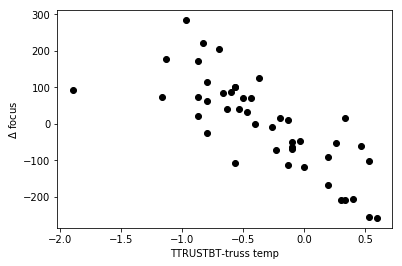

In [9]:
'''
difference between truss temp and TTRUSTBT most significant
plot what it looks like
'''
plt.plot(f['TTRUSTBT']-mt,df,'ko')
plt.xlabel('TTRUSTBT-truss temp')
plt.ylabel(r'$\Delta$ focus')
plt.show()

Text(5,-220,'new least squares, rms =78.672')

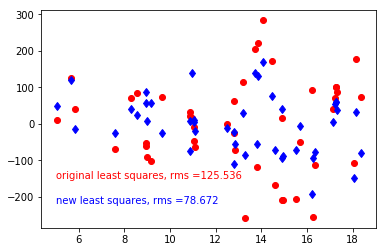

In [10]:
'''
indeed, that looks pretty significant
get coefficients for it and look at improvement
'''
dt = f['TTRUSTBT']-mt
A = np.vstack([dt, np.ones(len(mt))]).T
md, cd = np.linalg.lstsq(A, f['focus_C']-afme)[0]
modzd = afme+md*dt+cd
rmsd = np.std(f['focus_C']-modzd)
plt.plot(mt,f['focus_C']-afme,'ro')
plt.text(5,-150,'original least squares, rms ='+str(np.round(rmsm,3)),color='r')
plt.plot(mt,f['focus_C']-modzd,'bd')
plt.text(5,-220,'new least squares, rms ='+str(np.round(rmsd,3)),color='b')

In [11]:
'''
Nice improvement, repeat procedure to see what else still correlates
'''
df = f['focus_C']-modzd
vl = []
ql = []
hquant = ['TARGTRA','TARGTDEC','MOUNTHA','MOUNTAZ','MOUNTEL','AIRMASS','CI-T1','CI-T2','CI-T3','CI-T4','CI-T5','TDEWPNT','TAIRFLOW','TAIRITMP','TAIROTMP','TAIRTEMP','TCASITMP','TCASOTMP','TCSITEMP','TCSOTEMP','TDBTEMP','TPMNIBT','TPMEOBT','TTRSTEMP','TTRWTEMP','TTRUETBT','TTRUETTT','TTRUNTBT','TTRUNTTT','TTRUSTBT','TTRUSTST','TTRUSTTT','TTRUTSBT','TTRUTSMT','TTRUTSTT','TTRUWTBT','TTRUWTTT','AMNIENTN','AMBIENTS','OUTTEMP','TELBASE']
for q in hquant:
    w = (f[q] != 0) #some quantities are 0 when there was no data
    w &= (f[q]*0 == 0)#some quantities are NaN
    print(q,np.corrcoef(f[w][q],df[w])[0][1],len(f[w]))
    vl.append(np.corrcoef(f[w][q],df[w])[0][1])
    ql.append(q)
    dq = f[q][w]-mt[w]
    print(np.corrcoef(dq,df[w])[0][1],len(f[w]))
    vl.append(np.corrcoef(dq,df[w])[0][1])
    ql.append('d'+q)

print('\n')
'''
print out most significant correlations
'''
vl = np.array(vl)
w = vl*0 != 0
vl[w] = 0
ind = np.argmax(vl)
print(vl[ind],ql[ind])
indm = np.argmin(vl)
print(vl[indm],ql[indm])    

TARGTRA 0.208263829319 45
0.224927059202 45
TARGTDEC 0.429696617605 45
0.526110796018 45
MOUNTHA 0.176623614963 45
0.230454473857 45
MOUNTAZ 0.0136665654252 45
0.0227096072404 45
MOUNTEL 0.190921729709 45
0.261723045992 45
AIRMASS -0.342090683955 45
0.264792875675 45
CI-T1 -0.362772086482 45
-0.203409507574 45
CI-T2 -0.374609329858 45
-0.233686490103 45
CI-T3 -0.376410127575 45
-0.231812827422 45
CI-T4 -0.385174490907 45
-0.247541305087 45
CI-T5 -0.332188843084 45
-0.131838739409 45
TDEWPNT 0.223996256919 45
0.356381669278 45
TAIRFLOW nan 1
nan 1
TAIRITMP -0.268220610895 45
0.23247281128 45
TAIROTMP -0.294576459094 45
0.219933894721 45
TAIRTEMP -0.281831043409 45
0.199779973856 45
TCASITMP nan 45
0.285597922154 45
TCASOTMP -0.263942667932 45
0.177763577135 45
TCSITEMP -0.222980309385 45
0.241274402627 45
TCSOTEMP -0.281460907364 45
0.0763336028302 45
TDBTEMP -0.177431267979 45
0.214701978864 45
TPMNIBT -0.353339761279 45
0.0800779771847 45
TPMEOBT -0.288188488579 45
0.123691425572 45
T

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:3159: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:3093: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:3093: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:3168: RuntimeWarning: in

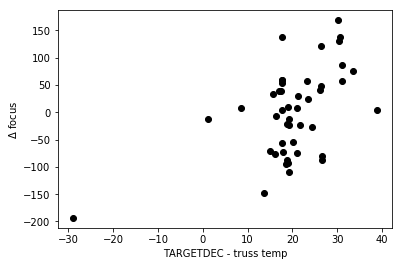

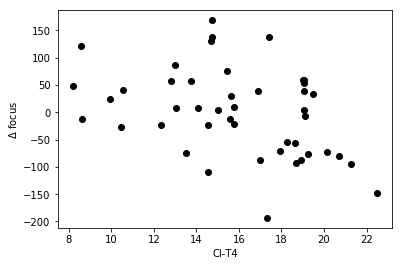

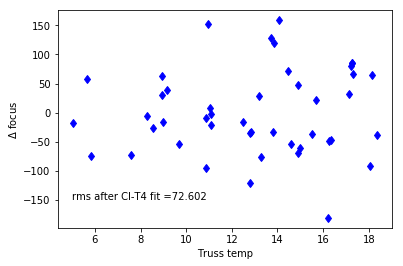

In [12]:
'''
dTARGETDEC is probably noise (difference between temp and DEC); plot it anyway
CI-T4 is temp on focal plane, so this could be tracking temperature differences
'''
plt.plot(f['TARGTDEC']-mt,f['focus_C']-modzd,'ko')
plt.xlabel('TARGETDEC - truss temp')
plt.ylabel(r'$\Delta$ focus')
plt.show()
plt.plot(f['CI-T4'],f['focus_C']-modzd,'ko')
plt.xlabel('CI-T4')
plt.ylabel(r'$\Delta$ focus')

plt.show()
'''
CI-T4 trend looks like it could be something, get correction 
'''
df = f['focus_C']-modzd
A = np.vstack([f['CI-T4'], np.ones(len(mt))]).T
mt4, ct4 = np.linalg.lstsq(A, df)[0]
modz4 = modzd+mt4*(f['CI-T4'])+ct4
rms4 = np.std(f['focus_C']-modz4)
plt.plot(mt,f['focus_C']-modz4,'bd')
plt.xlabel('Truss temp')
plt.ylabel(r'$\Delta$ focus')
plt.text(5,-150,'rms after CI-T4 fit ='+str(np.round(rms4,3)))
plt.show()


In [13]:
'''
do another round
'''
df = f['focus_C']-modz4
vl = []
ql = []
hquant = ['CI-T1','CI-T2','CI-T3','CI-T4','CI-T5','TDEWPNT','TAIRFLOW','TAIRITMP','TAIROTMP','TAIRTEMP','TCASITMP','TCASOTMP','TCSITEMP','TCSOTEMP','TDBTEMP','TPMNIBT','TPMEOBT','TTRSTEMP','TTRWTEMP','TTRUETBT','TTRUETTT','TTRUNTBT','TTRUNTTT','TTRUSTBT','TTRUSTST','TTRUSTTT','TTRUTSBT','TTRUTSMT','TTRUTSTT','TTRUWTBT','TTRUWTTT','AMNIENTN','AMBIENTS','OUTTEMP','TELBASE']
for q in hquant:
    w = (f[q] != 0) #some quantities are 0 when there was no data
    w &= (f[q]*0 == 0)#some quantities are NaN
    print(q,np.corrcoef(f[w][q],df[w])[0][1],len(f[w]))
    vl.append(np.corrcoef(f[w][q],df[w])[0][1])
    ql.append(q)
    dq = f[q][w]-mt[w]
    print(np.corrcoef(dq,df[w])[0][1],len(f[w]))
    vl.append(np.corrcoef(dq,df[w])[0][1])
    ql.append('d'+q)

print('\n')
'''
print out most significant correlations
'''
vl = np.array(vl)
w = vl*0 != 0
vl[w] = 0
ind = np.argmax(vl)
print(vl[ind],ql[ind])
indm = np.argmin(vl)
print(vl[indm],ql[indm])    

CI-T1 0.0234793656289 45
-0.1514045908 45
CI-T2 0.0111299238502 45
-0.176847344015 45
CI-T3 0.00910389339966 45
-0.171218862038 45
CI-T4 4.09739324009e-17 45
-0.201228082053 45
CI-T5 0.0541869450359 45
-0.074652174996 45
TDEWPNT 0.222547033289 45
0.0633595387028 45
TAIRFLOW nan 1
nan 1
TAIRITMP 0.0922772953606 45
-0.0443976657678 45
TAIROTMP 0.0604028656589 45
-0.0749928528997 45
TAIRTEMP 0.0803259192509 45
0.0891620166234 45
TCASITMP nan 45
-0.0769935449955 45
TCASOTMP 0.103751975184 45
0.0855127650884 45
TCSITEMP 0.136230434357 45
0.14658067185 45
TCSOTEMP 0.0873617815464 45
0.0639625736708 45
TDBTEMP 0.128874577994 45
0.0658532159204 45
TPMNIBT -0.0227464236163 45
-0.151728493177 45
TPMEOBT 0.0463129402625 45
-0.0753542574217 45
TTRSTEMP 0.0749398423508 45
0.0140173610309 45
TTRWTEMP 0.0900121847908 45
0.261567767697 45
TTRUETBT 0.0766495467561 45
-0.0114169040586 45
TTRUETTT 0.0923053120641 45
0.119210645418 45
TTRUNTBT 0.0942814146022 45
0.103637337048 45
TTRUNTTT 0.104024784715 4

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:3159: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:3093: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:3093: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:3168: RuntimeWarning: in

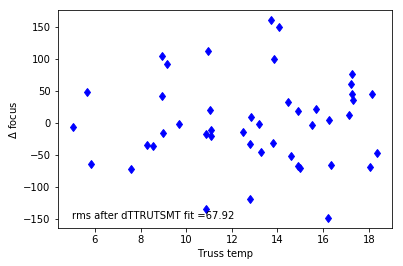

-119.951547577 -182.965785193 -8.5942780788 309.343075566
-7352.7841813


In [14]:
'''
get correction for dTTRUTSMT
'''

A = np.vstack([f['TTRUTSMT']-mt, np.ones(len(mt))]).T
mtsm, ctsm = np.linalg.lstsq(A, df)[0]
modzsm = modz4+mtsm*(f['TTRUTSMT']-mt)+ctsm
rmssm = np.std(f['focus_C']-modzsm)
plt.plot(mt,f['focus_C']-modzsm,'bd')
plt.xlabel('Truss temp')
plt.ylabel(r'$\Delta$ focus')
plt.text(5,-150,'rms after dTTRUTSMT fit ='+str(np.round(rmssm,3)))
plt.show()
print(m,md,mt4,mtsm)
print(c+cd+ct4+ctsm)

'\nthat is good within 0.2 degrees\n'

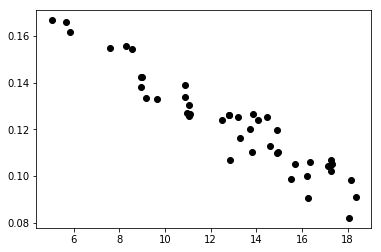

In [15]:
'''
that is now about as good as it gets for dT/dt correction
total equation is
Z = -7353.-119.95*trusstemp-182.97*(TTRUSTBT-trusstemp)-8.59*CI-T4+309.3*(TTRUTSMT-trusstemp)
'''
#confirm equation
modztot = -7353.-119.95*mt-182.97*(f['TTRUSTBT']-mt)-8.59*f['CI-T4']+309.3*(f['TTRUTSMT']-mt)
plt.plot(mt,modzsm-modztot,'ko')
'''
that is good within 0.2 degrees
'''

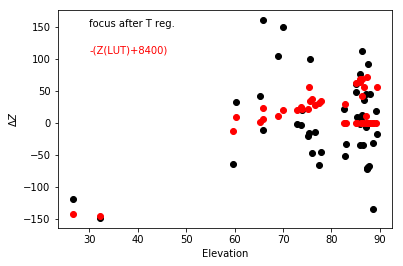

'\nresidual vs. elevation agrees pretty well with -(zlut+8400); this is opposite of what LUT+autofocus does\n'

In [16]:
'''
Now see if LUT improves things
'''
df =  f['focus_C']-  modztot
plt.plot(f['MOUNTEL'],df,'ko')
plt.plot(f['MOUNTEL'],-(zlut+8400),'ro')
plt.xlabel('Elevation')
plt.ylabel(r'$\Delta Z$')
plt.text(30,150,'focus after T reg.',color='k')
plt.text(30,110,'-(Z(LUT)+8400)',color='r')
plt.show()
'''
residual vs. elevation agrees pretty well with -(zlut+8400); this is opposite of what LUT+autofocus does
'''

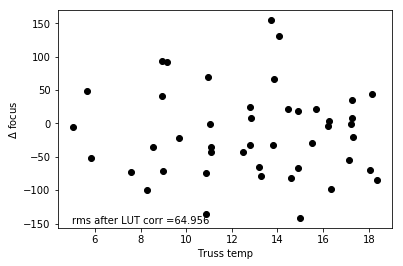

In [17]:
'''
Now look at how much LUT improves things
'''
modzlut = modztot-(zlut+8400)
rmslut = np.std(f['focus_C']-modzlut)
plt.plot(mt,f['focus_C']-modzlut,'ko')
plt.xlabel('Truss temp')
plt.ylabel(r'$\Delta$ focus')
plt.text(5,-150,'rms after LUT corr ='+str(np.round(rmslut,3)))
plt.show()
